# Direct Imputation

In [1]:
import numpy as np
import scipy.stats as stats
# import scipy.optimize as opt
# import scipy.io
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

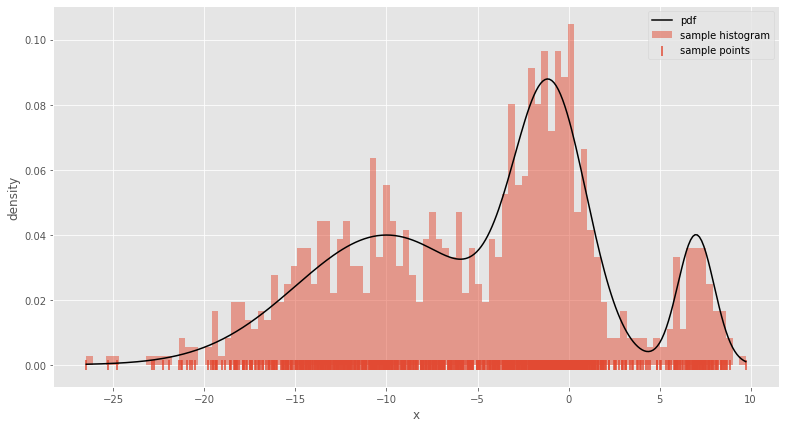

In [2]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Derivative-based imputation

The original paper (*Newey and Powell (1987) Asymmetric Least Squares Estimation and Testing*) introducing expectile regression gives the following theorem:

> **Theorem 1 (iv)** [paraphrased]
> 
> Let $F$ be the continuously differentiable cumulative density function
> of a random variable.
> Let $I_F = \{y | 0 < F(y) < 1\}$.
> Let $\epsilon(\tau)$ be the expectile function (the one minimising the
> asymmetric least squares regression loss).
> 
> * $\epsilon(\tau)$ is continuously differentiable.
>   Let $\epsilon'(\tau)$ be its derivative.
> * Let $\mu$ be the mean of $F$ ($\mu=\epsilon(0.5)$).
>   Then for $y \in I_F$ with $y \neq \mu$, and
>   $\tau(y) \doteq \epsilon^{-1}(y)$,
> 
>     $$F(y)
        =
        -\frac{
            y - \mu + \tau(y) \epsilon'(\tau(y)) (1-2\tau(y))
        }{
            \epsilon'(\tau(y))(1-2\tau(y))^2
        }
      $$

Could we differentiate again to get $f'(y)$, and thus have an approximate imputation procedure given enough expectiles? Or is there not enough information here? What's the catch?

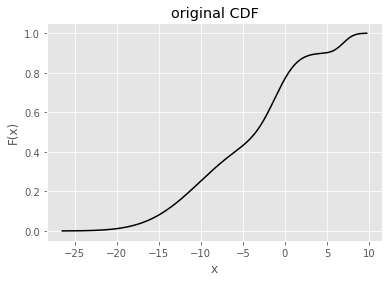

In [3]:
# Plot cumulative distribution function of sample
x = GMM_X
fx = GMM_Y
dx = x[1]-x[0]
Fx = fx.cumsum()*dx
plt.plot(x, Fx, color="black")
plt.xlabel("x")
plt.ylabel("F(x)")
plt.title("original CDF")
plt.show()

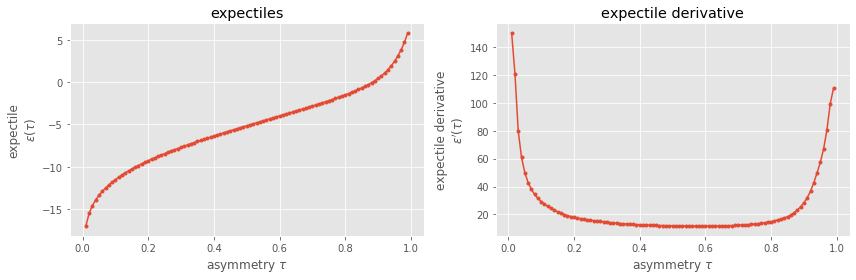

In [4]:
# Plot expectile function and derivative
taus  = np.linspace(0.01, 0.99, 99)
expt  = expectile(SAMPLE, taus)
exptd = np.gradient(expt, taus)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(taus, expt, marker=".")
ax1.set_title("expectiles")
ax1.set_xlabel("asymmetry $\\tau$")
ax1.set_ylabel("expectile\n$\\epsilon(\\tau)$")
ax2.plot(taus, exptd, marker=".")
ax2.set_title("expectile derivative")
ax2.set_xlabel("asymmetry $\\tau$")
ax2.set_ylabel("expectile derivative\n$\\epsilon'(\\tau)$")
plt.tight_layout()
plt.show()

<ipython-input-5-772d54be0c37>:13: RuntimeWarning: divide by zero encountered in true_divide
  Fy = - (y - m + taus[t] * exptd[t] * (1-2*taus[t])) / (exptd[t] * (1-2*taus[t]) ** 2)
/usr/local/lib/python3.8/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


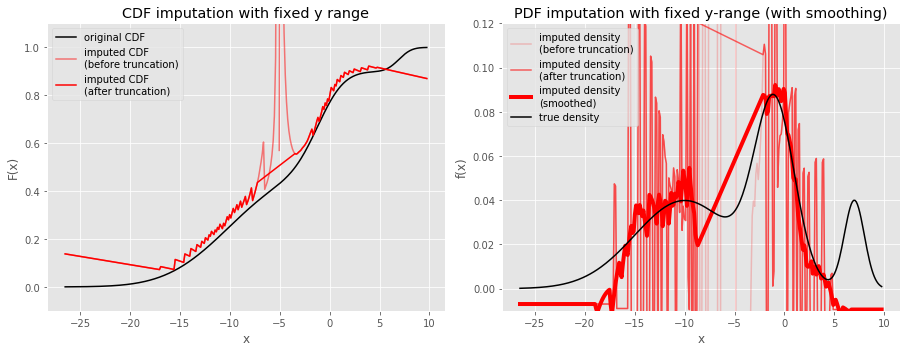

In [5]:
# Try out the formula
#          y - \mu + \tau_y * \epsilon'(\tau_y) * (1-2\tau_y)
# F(y) = - --------------------------------------------------
#                  \epsilon'(\tau_y) * (1-2\tau_y)^2

# use the original sample xs as the ys:
y = GMM_X
m = SAMPLE.mean()
# invert the expectiles function:
t = np.searchsorted(expt[:-1], y)

# compute the CDF
Fy = - (y - m + taus[t] * exptd[t] * (1-2*taus[t])) / (exptd[t] * (1-2*taus[t]) ** 2)

# And the derivative/PDF:
fy = np.gradient(Fy, y)

# try some smoothing
# (NOTE: before or after gradient makes essentially no difference here)
fys = signal.savgol_filter(fy, 31, 2)


# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, alpha=0.5, label="imputed CDF\n(before truncation)", color="red")
# truncate around the mean, where the calculation explodes
_m = np.where(np.abs(taus[t] - 0.5) > 0.15)
ax1.plot(y[_m], Fy[_m], label="imputed CDF\n(after truncation)", color="red")
ax1.set_ylim([-0.1, 1.1])
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.legend()
ax1.set_title("CDF imputation with fixed y range")

ax2.plot(y, fy, alpha=0.2, color="red", label="imputed density\n(before truncation)")
# cut out the near-mean values again
_m = np.where(np.abs(taus[t] - 0.5) > 0.25)
ax2.plot(y[_m], fy[_m], color="red", alpha=0.6, label="imputed density\n(after truncation)")
ax2.plot(y[_m], fys[_m], color="red", linewidth=4, label="imputed density\n(smoothed)")
ax2.plot(x, fx, color="black", label="true density")
ax2.set_ylim([-0.01, 0.12])
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.legend()
ax2.set_title("PDF imputation with fixed y-range (with smoothing)")

plt.tight_layout()
plt.show()

<ipython-input-6-fa4130f71974>:12: RuntimeWarning: divide by zero encountered in true_divide
  Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)


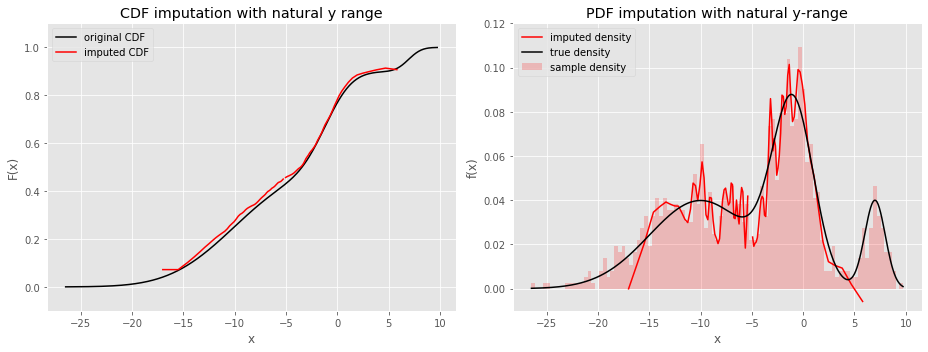

In [6]:
# Given the formula,
#          y - \mu + \tau_y * \epsilon'(\tau_y) * (1-2\tau_y)
# F(y) = - --------------------------------------------------
#                  \epsilon'(\tau_y) * (1-2\tau_y)^2
# and our intention to take derivatives afterwards,
# We should probably use the expectiles as the y values!
# Then there's no need for this 't' inverse step, which was coarse!
# (we can just use the original taus array!)
y = expt
m = SAMPLE.mean()

Fy = - (y - m + taus * exptd * (1-2*taus)) / (exptd * (1-2*taus) ** 2)
fy = np.gradient(Fy, y)

# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.set_title("CDF imputation with natural y range")
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, label="imputed CDF",  color="red")
ax1.set_ylim([-0.1, 1.1])
ax1.legend()

ax2.set_title("PDF imputation with natural y-range")
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.plot(y, fy, label="imputed density", color="red")
ax2.plot(x, fx, label="true density", color="black")
ax2.hist(SAMPLE, density=True, bins=99, label="sample density", color="red", alpha=0.2)
ax2.set_ylim([-0.01, 0.12])
ax2.legend()

plt.tight_layout()
plt.show()

That works so well!

In fact, the spiky-ness is revealed to be recovering the noise in the sample itself! (Matches perfectly with the histogram)

Let's turn it into a function so that we can play with the tau range and density

In [7]:
def direct_impute(taus, epss=None, sample=SAMPLE, x=GMM_X, fx=GMM_Y, smoothing_bins=50, ylim=True):
    Fx = fx.cumsum()*(x[1]-x[0])
    # note: remove tau=0.5
    # TODO: make this parametric
    half = np.where(taus == 0.5)
    taus = np.delete(taus, half)
    if epss is not None:
        epss = np.delete(epss, half)
    else:
        epss = expectile(sample, taus)
    
    y = epss
    m = sample.mean()
    
    # epss'
    epssd = np.gradient(epss, taus)
    
    Fy = - (y - m + taus * epssd * (1-2*taus)) / (epssd * (1-2*taus) ** 2)
    fy = np.gradient(Fy, y)
    
    # to remove the noisy-ness we can do some simple fixed-width-bin smoothing
    w = (y[-1]-y[0])/smoothing_bins
    fys = np.zeros_like(fy)
    for i in range(len(y)):
        # TODO: vectorise
        fys[i] = np.mean(fy[np.abs(y - y[i]) < w])

    # plot the resulting imputed functions next to the original functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.set_title("CDF imputation with natural y range")
    ax1.set_xlabel("x")
    ax1.set_ylabel("F(x)")
    ax1.plot(x, Fx, label="original CDF", color="black")
    ax1.plot(y, Fy, label="imputed CDF",  color="red")
    ax1.legend()

    ax2.set_title("PDF imputation with natural y-range")
    ax2.set_xlabel("x")
    ax2.set_ylabel("f(x)")
    ax2.plot(y, fy, label="imputed density\n(before smoothing)", color="red", alpha=0.5)
    ax2.plot(y, fys,label="imputed density\n(after smoothing)", color="red", linewidth=4)
    ax2.plot(x, fx, label="true density", color="black")
    ax2.legend()
    
    if ylim:
        ax1.set_ylim([-0.1, 1.1])
        ax2.set_ylim([-0.01, 0.12])
    
    plt.tight_layout()
    plt.show()

99 taus


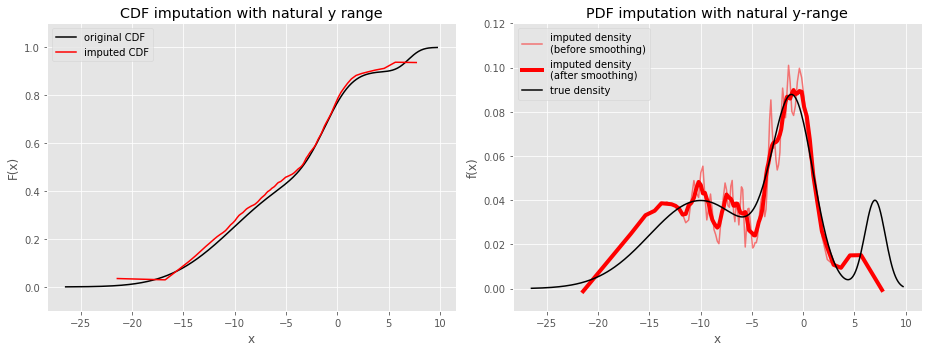

999 taus


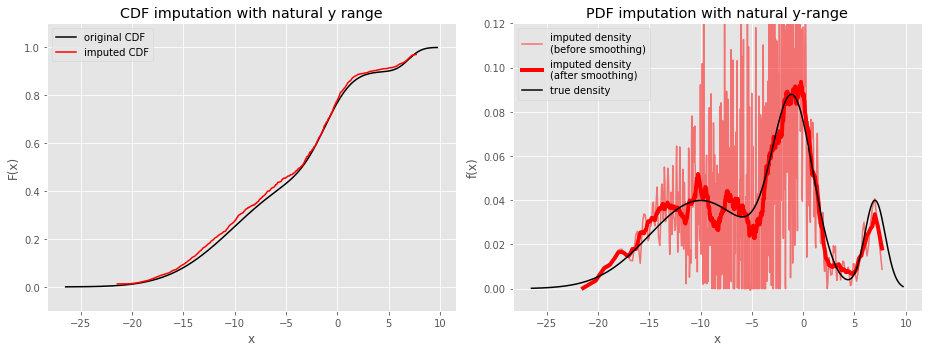

99 low taus


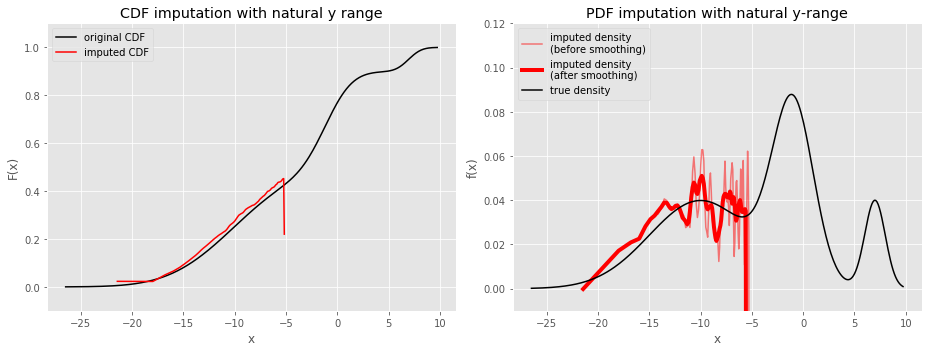

99 high taus


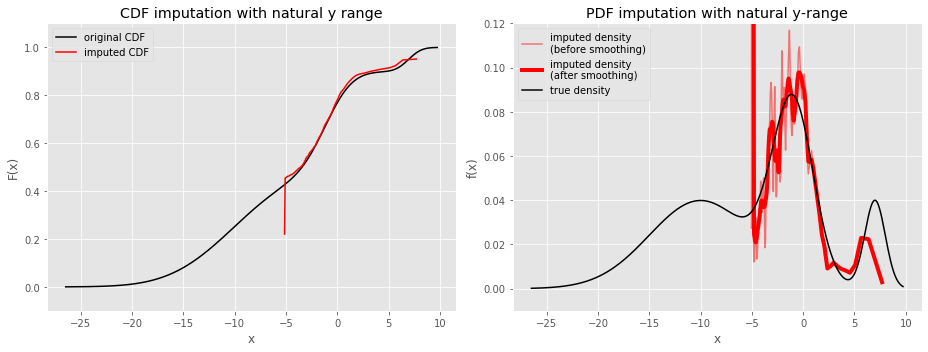

In [8]:
print("99 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 99))
print("999 taus")
direct_impute(taus=np.linspace(0.001, 0.999, 999))
print("99 low taus")
direct_impute(taus=np.linspace(0.001, 0.499, 99))
print("99 high taus")
direct_impute(taus=np.linspace(0.501, 0.999, 99))

### Recovering the distribution from neural taus

How does the *neural* tau distribution go? (the expectiles were trained on a different
distribution, but we can still use the tau values for OUR distribution):

40 evenly spaced taus


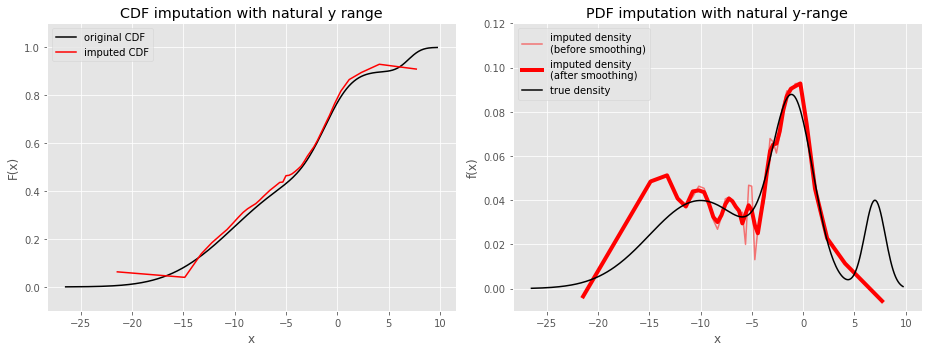

neural taus


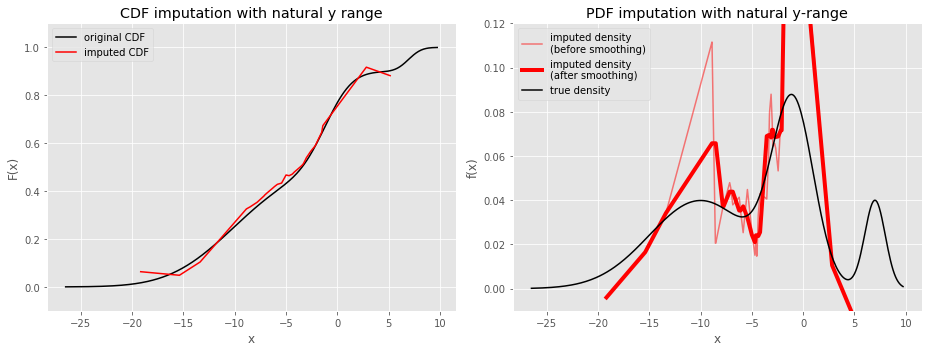

neural taus with a bit more smoothing


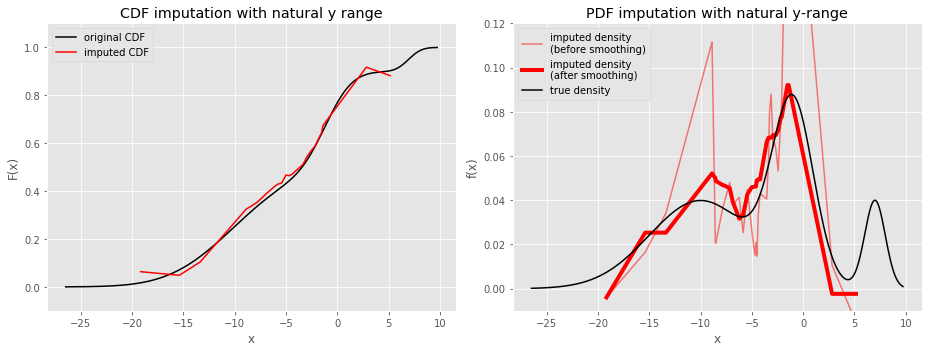

In [10]:
print("40 evenly spaced taus")
direct_impute(taus=np.linspace(0.001, 0.999, 40))

print("neural taus")
neural_taus = np.array([0.00336147, 0.02108205, 0.04991431, 0.24368197, 0.42196866,
                        0.22353116, 0.47702077, 0.29611582, 0.36181693, 0.442517  ,
                        0.51354238, 0.29136287, 0.24596278, 0.33895973, 0.41090296,
                        0.54775816, 0.2238155 , 0.98442344, 0.53931528, 0.41450776,
                        0.56729758, 0.58246691, 0.68976626, 0.34638865, 0.55480031,
                        0.5570765 , 0.66221661, 0.71219295, 0.65433601, 0.79852221,
                        0.75769016, 0.70370061, 0.7311324 , 0.63879298, 0.66074851,
                        0.68294063, 0.75187872, 0.80620104, 0.67485657, 0.95602078])
# note: we need them to be sorted
neural_taus.sort()
direct_impute(taus=neural_taus)

print("neural taus with a bit more smoothing")
direct_impute(taus=neural_taus, smoothing_bins=10)

Answer: Not bad! But could probably be better. And, it's not clear how much smoothing to rely on.

What if we use the actual reward distribution from the study? That is...

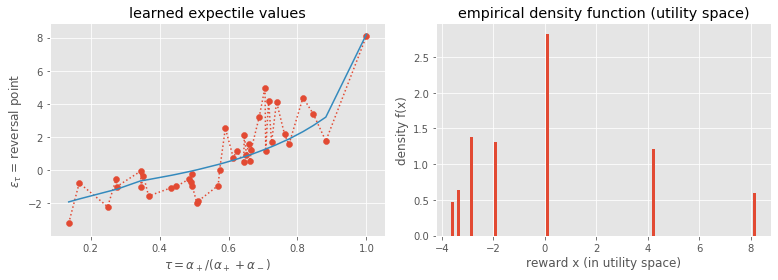

In [11]:
# DEEPMIND DATA DUMP (variables renamed, comments added)
# juice volumes in micro-litres
juice_vols = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
# juice volumes in estimated utility space
juice_utils = np.array([-3.63887402657031,-3.31870708722146,  -2.84609534101164,
                        -1.86975535870141, 0.0350553672638314, 4.18830501181676,
                         8.20381872775166])
# juice empirical probabilities
juice_probs = np.array([0.06612594, 0.09090909, 0.14847358, 0.15489467,
                       0.31159175, 0.1509519 , 0.07705306])
# estimated neural asymmetries (neural taus)
neural_asyms = np.array([0.665148134736891,0.65208410906952,0.613744203780139,
                         0.775212700883808,0.707915816841008,0.570103354233973,
                         0.882127332095316,0.508575044586604,0.486016624470385,
                         0.490519368353783,0.353180140687647,0.34502602367731,
                         0.274459190431141,0.624608202330519,0.511245599898681,
                         0.275963695780172,0.574282416537853,0.494461077846514,
                         0.249573167763381,1.01616027303818, 0.136555552978056,
                         0.716127024137563,0.658310695222273,0.493856204792549,
                         0.815972879462343,0.433624365681467,0.643716612535732,
                         0.724905499014785,0.3681787227383,  0.705733696238299,
                         0.76246447053036, 0.739327730375869,0.590831434674471,
                         0.346659782367775,0.449000983609862,0.662902110431635,
                         0.645905621173483,0.16704746815482, 0.846125077182948,
                         0.689060956288534])
neural_asyms = np.clip(neural_asyms, 0., 1.)
# estimated neural expectile values (neural reversal points) in utility space
neural_expts = np.array([ 1.19796718528621,  0.909588860368442,  0.768290210301997,
                          1.5580695804582,   1.18069340075516,  -0.917277009040899,
                          1.76606208326366, -1.99990282124502,  -0.52508567014901,
                         -0.72677865537825, -0.317750664489987, -0.0555191676477702,
                         -0.498294836948614, 1.16799418233059,  -1.86969915298433,
                         -0.980841264017123, 0.0346564269295749,-0.917418194178877,
                         -2.19520456394411,  8.10381872775166,  -3.18979437039029,
                          4.18823808094621,  1.59258444073823,  -0.210742609830699,
                          4.38901915501838, -1.0533487207759,    0.472919232719837,
                          1.69636515581653, -1.55263442315208,   4.99096579152878,
                          2.16489750392618,  4.1202653189854,    2.53839455360929,
                         -0.981001892834966,-0.967509962517738,  0.554271248178451,
                          2.11181823971785, -0.766921663162386,  3.38445321759506,
                          3.21931839438752])
# END DEEPMIND DATA DUMP

# i'm going to need these to be sorted according to the taus
order = np.argsort(neural_asyms)
neural_asyms = neural_asyms[order]
neural_expts = neural_expts[order]

# and i'm going to need a sample
neural_sample = np.random.choice(juice_utils, p=juice_probs, size=1000)

# let's take a look!
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.set_title("learned expectile values")
ax1.set_ylabel(r"$\epsilon_\tau$ = reversal point")
ax1.set_xlabel(r"$\tau = \alpha_+ / (\alpha_++\alpha_-)$")
ax1.plot(neural_asyms, neural_expts, linestyle=":")
ax1.plot(neural_asyms, expectile(neural_sample, neural_asyms))
ax1.scatter(neural_asyms, neural_expts)
ax2.set_title("empirical density function (utility space)")
ax2.set_xlabel("reward x (in utility space)")
ax2.set_ylabel("density f(x)")
ax2.hist(neural_sample, bins=100, density=True)
plt.tight_layout()
plt.show()

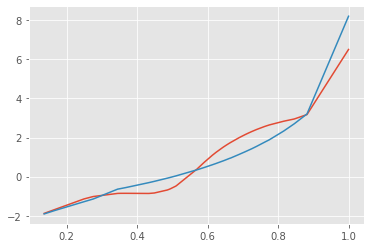

In [53]:
# i'm going to need the expectiles to be roughly smoothed so that the
# gradient calculation makes sense
def smooth(fy, y, w=1):
    fys = np.zeros_like(fy)
    for i in range(len(y)):
        # TODO: vectorise
        dists = np.exp(-(y-y[i])**2/w)
        fys[i] = np.average(fy, weights=dists)
    return fys
smooth_expts = smooth(neural_expts, neural_asyms, w=0.01)
plt.plot(neural_asyms, smooth_expts)
# compare to expectiles of the sample
plt.plot(neural_asyms, expectile(neural_sample, neural_asyms))
plt.show()

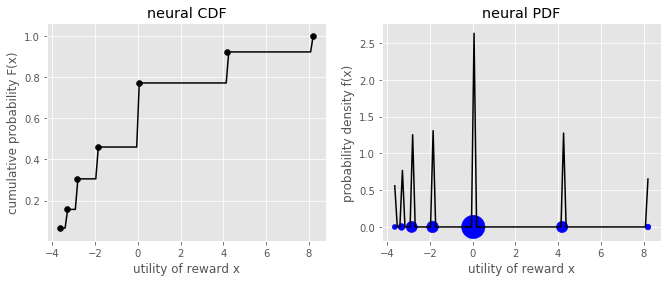

In [54]:
neural_x_range = [neural_sample.min(), neural_sample.max()]
neural_x_res = 100
neural_x = np.linspace(*neural_x_range, neural_x_res)
neural_dx = np.diff(neural_x_range) / neural_x_res
neural_fx = np.zeros_like(neural_x)
neural_fx[np.searchsorted(neural_x, juice_utils)] = juice_probs / neural_dx
neural_Fx = neural_fx.cumsum()*neural_dx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.set_title("neural CDF")
ax1.set_xlabel("utility of reward x")
ax1.set_ylabel("cumulative probability F(x)")
ax1.scatter(juice_utils, juice_probs.cumsum(), color="black")
ax1.plot(neural_x, neural_Fx, color="black")
ax2.set_title("neural PDF")
ax2.set_xlabel("utility of reward x")
ax2.set_ylabel("probability density f(x)")
ax2.scatter(juice_utils, np.zeros_like(juice_utils), s=(75*juice_probs)**2, color="blue")
ax2.plot(neural_x, neural_fx, color="black")
plt.show()

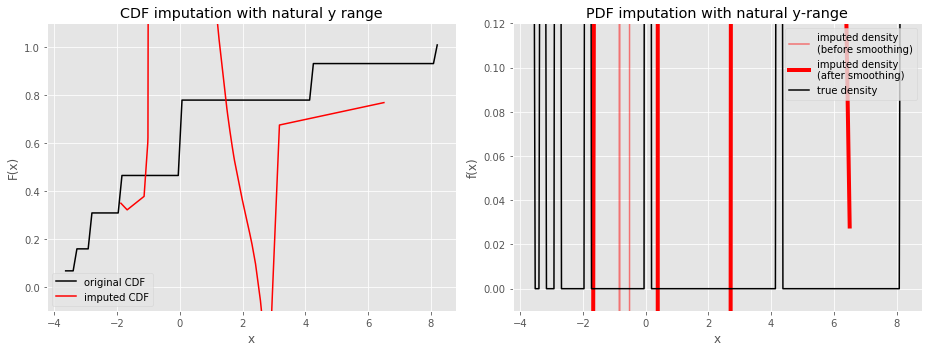

In [56]:
direct_impute(taus=neural_asyms, epss=smooth_expts, sample=neural_sample,
              x=neural_x, fx=neural_fx, smoothing_bins=50, ylim=True)

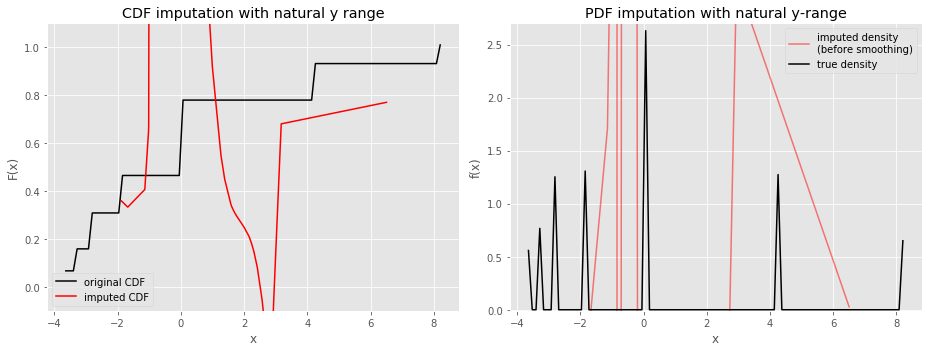

In [82]:
taus = neural_asyms
epss = neural_expts
x = neural_x
fx = neural_fx
smoothing_bins = 50
ylim = True

Fx = fx.cumsum()*(x[1]-x[0])

half = np.where(np.isclose(taus, 0.5, atol=0.01))
taus = np.delete(taus, half)
epss = np.delete(epss, half)
epss = smooth(epss, taus, w=0.01)

y = epss
m = np.average(juice_utils, weights=juice_probs)

# epss'
epssd = np.gradient(epss, taus)

Fy = - (y - m + taus * epssd * (1-2*taus)) / (epssd * (1-2*taus) ** 2)
fy = np.gradient(Fy, y)

# to remove the noisy-ness we can do some simple fixed-width-bin smoothing
# w = (y[-1]-y[0])/smoothing_bins
# fys = np.zeros_like(fy)
# for i in range(len(y)):
#     # TODO: vectorise
#     fys[i] = np.mean(fy[np.abs(y - y[i]) < w])

# plot the resulting imputed functions next to the original functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ax1.set_title("CDF imputation with natural y range")
ax1.set_xlabel("x")
ax1.set_ylabel("F(x)")
ax1.plot(x, Fx, label="original CDF", color="black")
ax1.plot(y, Fy, label="imputed CDF",  color="red")
ax1.legend()

ax2.set_title("PDF imputation with natural y-range")
ax2.set_xlabel("x")
ax2.set_ylabel("f(x)")
ax2.plot(y, fy, label="imputed density\n(before smoothing)", color="red", alpha=0.5)
# ax2.plot(y, fys,label="imputed density\n(after smoothing)", color="red", linewidth=4)
ax2.plot(x, fx, label="true density", color="black")
ax2.legend()

if ylim:
    ax1.set_ylim([-0.1, 1.1])
    ax2.set_ylim([-0.01, 2.7])
plt.tight_layout()
# plt.show()